## Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


%matplotlib inline
plt.style.use('ggplot')


#read in scraped data
df = pd.read_csv('gofund_final.csv', index_col = False)


#drop duplicates and index, initial string formatting
df = df.dropna()
df = df.reset_index(drop = True)
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df.shares = df.shares.apply(str)

In [2]:
#convert string value to numerical value(1k->1000)
df.shares = np.where(df.shares.str.contains('k'), pd.to_numeric(df.shares.map(lambda x: str(x)[:-1]))*1000, df.shares)


#remove character values from goal feature
df.goal = df.goal.str.split().str[1]
df.goal = df.goal.str.strip()


#new feature labels the currency used in a campaign
df['currency']=df.goal.map(lambda x: str(x)[:1])


#remove currency notation
cols = ['num_of_dons', 'goal', 'total_collected']
df[cols] = df[cols].apply(lambda x: x.str.replace(',',''))
df[cols] = df[cols].apply(lambda x: x.str.replace('$',''))
df[cols] = df[cols].apply(lambda x: x.str.replace('€',''))
df[cols] = df[cols].apply(lambda x: x.str.replace('kr',''))


#convert string value to numerical value(1M->1000000, 1B->1000000000)
df.goal = np.where(df.goal.str.contains('M', na = False), pd.to_numeric(df.goal.map(lambda x: str(x)[:-1]))*1000000, df.goal)
df.goal = np.where(df.goal.str.contains('B', na = False), pd.to_numeric(df.goal.map(lambda x: str(x)[:-1]))*1000000000, df.goal)


#convert cols to float
df.total_collected = df.total_collected.astype(float)
df.goal = df.goal.astype(float)
df.num_of_dons = df.num_of_dons.astype(float)
df.shares = df.shares.astype(float)


#dictionary for mapping month names to values
mons = {'September':'09', 'October':'10', 'November':'11', 'December':'12','January':'01',
       'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07',
        'August':'08'}


#convert to column to date format
df.created_date = df.created_date.str.replace('Created','')
df.created_date = df.created_date.str.replace(',','')
df.created_date = df.created_date.replace(mons, regex=True)
df.created_date = df.created_date.str.split()
df.created_date = df.created_date.map(lambda x: '/'.join(x))
df.created_date = pd.to_datetime(df.created_date).dt.date


#date the data was scraped
scrape_date = datetime.date(2018, 10, 26)


#create descriptive stat columns
df['days_running'] = (scrape_date - df.created_date).dt.days + 1
df.shares = df.shares + 1 #need nonzero value
df['avg_donation'] = df.total_collected/df.num_of_dons
df['avg_daily_donations'] = df.total_collected/df.days_running
df['avg_shares'] = df.shares/df.num_of_dons
df['avg_daily_shares'] = df.shares/df.days_running
df['avg_dons_per_day'] = df.num_of_dons/df.days_running


#filter for active (incomplete funding), domestic campaigns that have run for at least two weeks
df = df[df.currency == '$']
df = df[df.total_collected < df.goal]
df = df[df.days_running >= 14]

In [3]:
#format descriptons, removing erroneous characters and excess whitespace
df.description = df.description.str.lower()
df.description = df.description.apply(lambda x: re.sub('\s+', ' ', x))
df.description = df.description.apply(lambda x: re.sub('[^\w\s]', '', x))
df = df[df.description != '']


#remove stopwords from descriptions
stop = stopwords.words('english')
df.description = df.description.apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#function builds Polarity and Subjectivity columns
def sentiment_func(x):
    sentiment = TextBlob(x['description'])
    x['polarity'] = sentiment.polarity
    x['subjectivity'] = sentiment.subjectivity
    return x


#apply function to df
df = df.apply(sentiment_func, axis=1)


#view changes
df.head(2)

,num_of_dons,category,created_date,description,goal,location,shares,title,total_collected,currency,days_running,avg_donation,avg_daily_donations,avg_shares,avg_daily_shares,avg_dons_per_day,polarity,subjectivity
3,855.0,Medical,2018-06-22,43 year old philip defonte husband father 3 yo...,250000.0,"STATEN ISLAND, NY",1801.0,AUTOLOGOUS T CELL TRANSPLANT,243320.0,$,127,284.584795,1915.905512,2.106433,14.181102,6.732283,0.112632,0.485317
4,2550.0,Medical,2018-06-25,kalea avery 6 years old experiencing several w...,250000.0,"REDONDO BEACH, CA",6101.0,Fight like the Averys,205434.0,$,124,80.562353,1656.725806,2.392549,49.201613,20.564516,0.023636,0.167273


## EDA

In [5]:
#all numerical features to float
x = ['num_of_dons', 'goal', 'avg_dons_per_day', 'shares', 'total_collected', 'days_running', 'avg_donation',
     'avg_daily_donations', 'avg_shares', 'avg_daily_shares', 'polarity', 'subjectivity']
df[x] = df[x].astype(float)

Text(0.5,1,'Collection Goal')

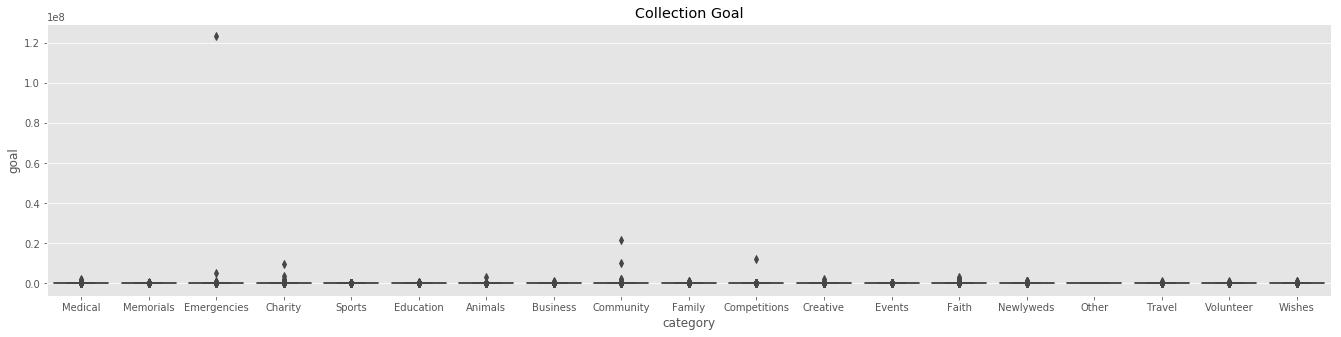

In [6]:
#boxplot of goal for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="goal", data=df)
x.set_title('Collection Goal')

Text(0.5,1,'Avg_Donations_per_Donor')

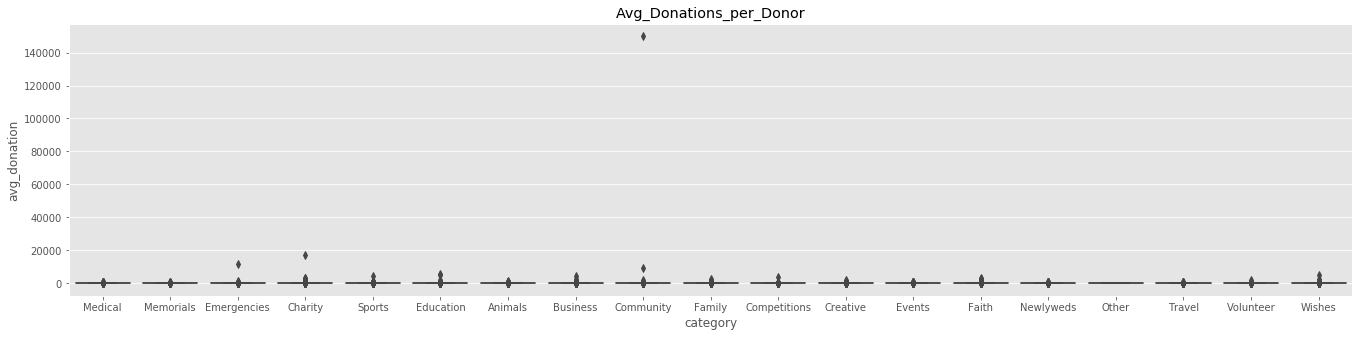

In [7]:
#boxplot of Avg_Donations_per_Donor for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="avg_donation", data=df)
x.set_title('Avg_Donations_per_Donor')

Text(0.5,1,'Avg_Shares_per_Donor')

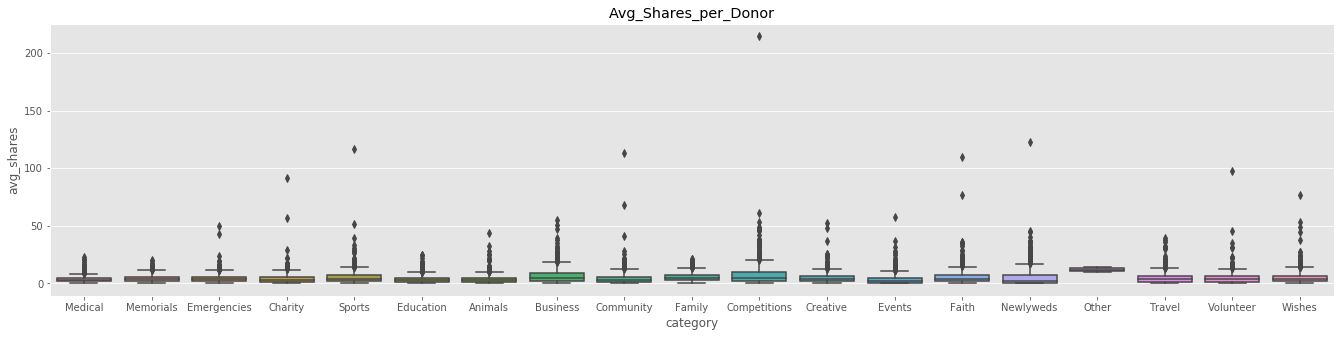

In [8]:
#boxplot of Avg_Shares_per_Donor for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="avg_shares", data=df)
x.set_title('Avg_Shares_per_Donor')

C:\Users\phili\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


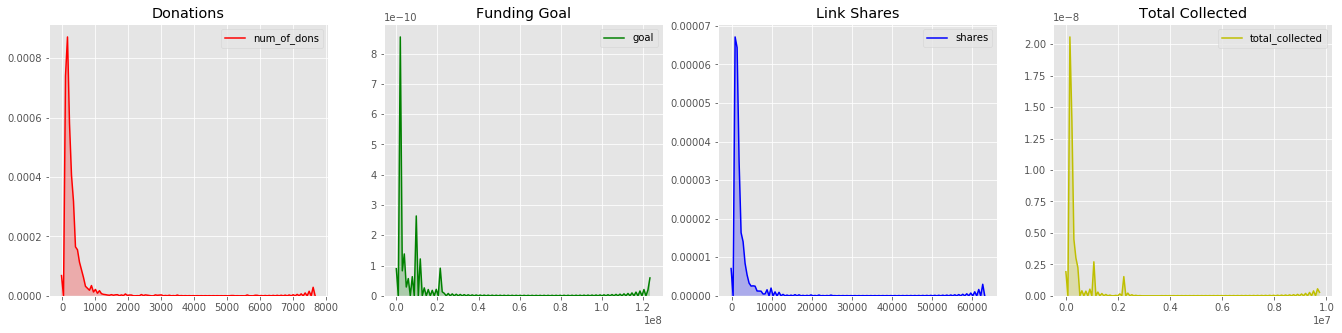

In [9]:
#density plots for numerical variables
fig, ax =plt.subplots(1,4, figsize=(23,5))

x = sns.kdeplot(df['num_of_dons'], shade = True, ax=ax[0], color="r")
x.set_title("Donations")

y = sns.kdeplot(df['goal'], shade = True, ax=ax[1], color="g")
y.set_title("Funding Goal")

q = sns.kdeplot(df['total_collected'], shade = True, ax=ax[3], color="y")
q.set_title("Total Collected")

z = sns.kdeplot(df['shares'], shade = True, ax=ax[2], color="b")
z.set_title("Link Shares")

plt.show()

Text(0.5,1,'Average_Donations_per_Day (#)')

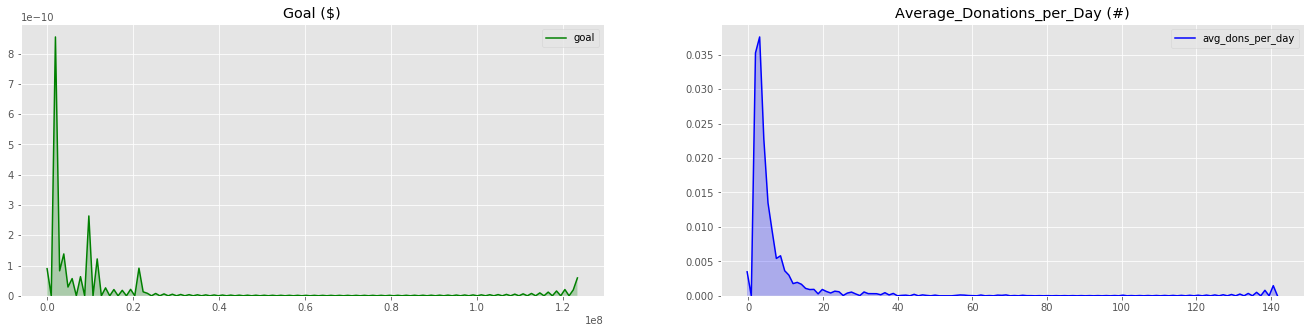

In [10]:
#density plots cont.
fig, ax =plt.subplots(1, 2, figsize=(23,5))

y = sns.kdeplot(df['goal'],shade=True, ax=ax[0], color="g")
y.set_title("Goal ($)")

x = sns.kdeplot(df['avg_dons_per_day'], shade=True, ax=ax[1], color="b")
x.set_title("Average_Donations_per_Day (#)")

Text(0.5,1,'Average_Daily_Donations ($/day)')

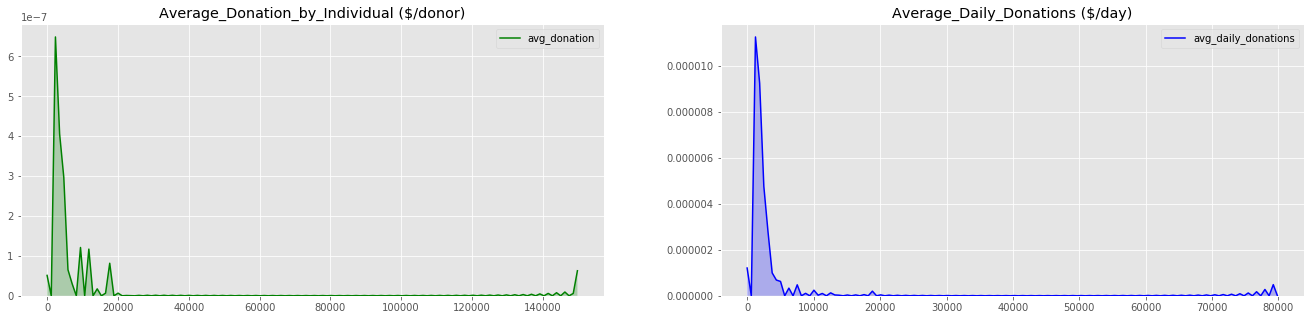

In [11]:
#density plots cont.
fig, ax =plt.subplots(1, 2, figsize=(23,5))

y = sns.kdeplot(df['avg_donation'], shade = True, ax=ax[0], color="g")
y.set_title("Average_Donation_by_Individual ($/donor)")

z = sns.kdeplot(df['avg_daily_donations'], shade = True, ax=ax[1], color="b")
z.set_title("Average_Daily_Donations ($/day)")

Text(0.5,1,'Average_Daily_Shares (shares/day)')

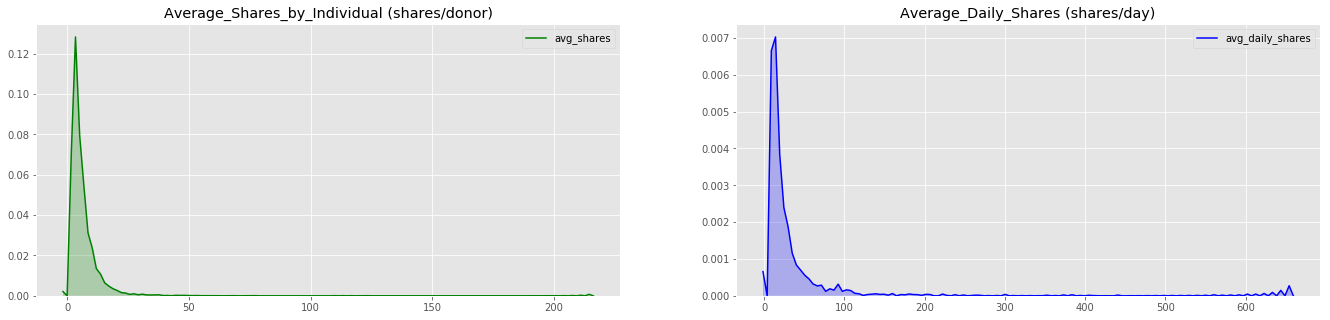

In [12]:
#density plots cont.
fig, ax =plt.subplots(1, 2, figsize=(23,5))

j = sns.kdeplot(df['avg_shares'], shade = True, ax=ax[0], color="g")
j.set_title("Average_Shares_by_Individual (shares/donor)")

k = sns.kdeplot(df['avg_daily_shares'], shade = True, ax=ax[1], color="b")
k.set_title("Average_Daily_Shares (shares/day)")

Text(0.5,1,'Subjectivity Score')

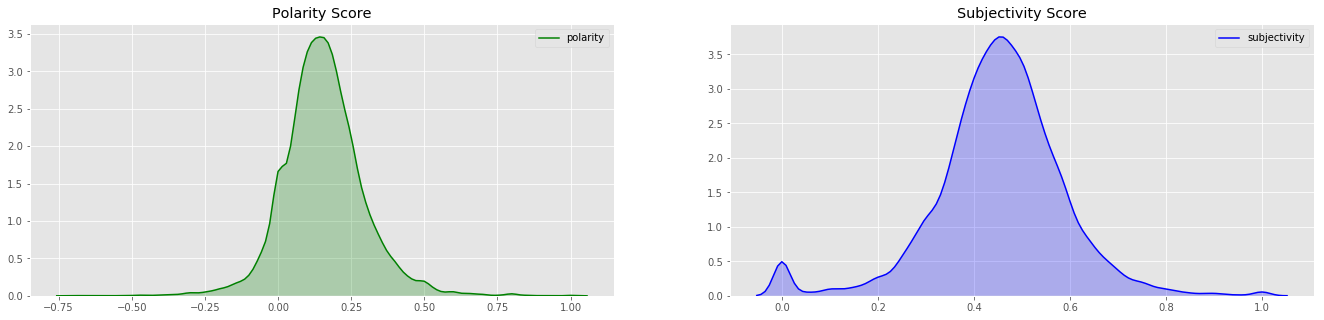

In [13]:
#density plots cont.
fig, ax =plt.subplots(1, 2, figsize=(23,5))

j = sns.kdeplot(df['polarity'], shade = True, ax=ax[0], color="g")
j.set_title("Polarity Score")

k = sns.kdeplot(df['subjectivity'], shade = True, ax=ax[1], color="b")
k.set_title("Subjectivity Score")

In [14]:
#log10 transformation for skewed features
tolog = ['num_of_dons', 'goal', 'avg_dons_per_day', 'shares', 'total_collected', 'avg_donation', 
         'avg_daily_donations', 'avg_shares', 'avg_daily_shares']

df_num_cols = ['category', 'num_of_dons', 'goal', 'avg_dons_per_day', 'shares', 'total_collected', 'days_running',
               'avg_donation', 'avg_daily_donations', 'avg_shares', 'avg_daily_shares', 'polarity', 'subjectivity']

df_numl = df[df_num_cols]

df_numl[tolog] = (df_numl[tolog]).apply(np.log10)

C:\Users\phili\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Text(0.5,1,'Goal Box')

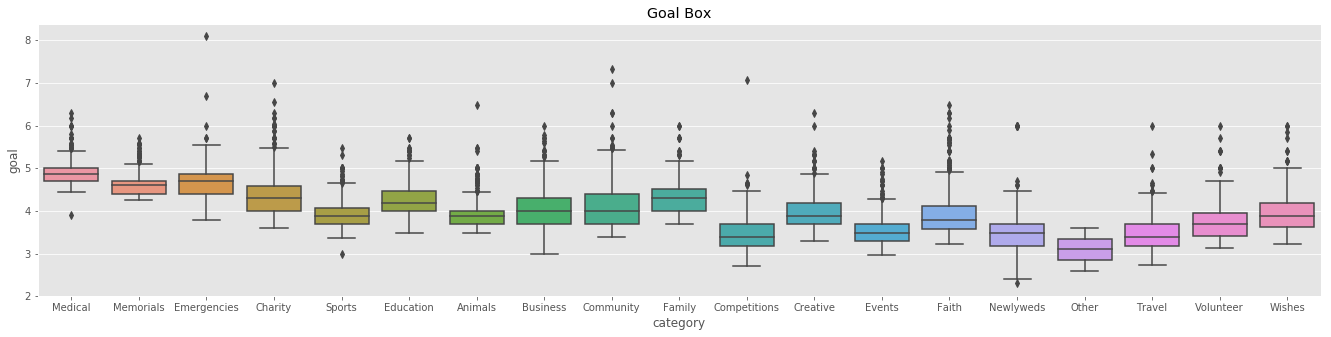

In [16]:
#transformed boxplot of goal for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="goal", data=df_numl)
x.set_title('Goal Box')

Text(0.5,1,'Average_Donations_per_Day Box')

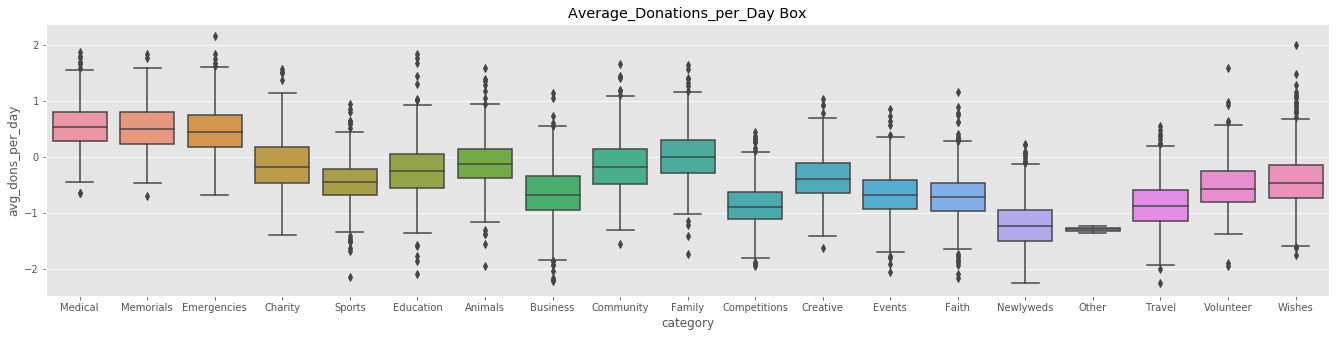

In [17]:
#transformed boxplot of Average_Donations_per_Day for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="avg_dons_per_day", data=df_numl)
x.set_title('Average_Donations_per_Day Box')

Text(0.5,1,'Average_Donation_Amount_per_Donor Box')

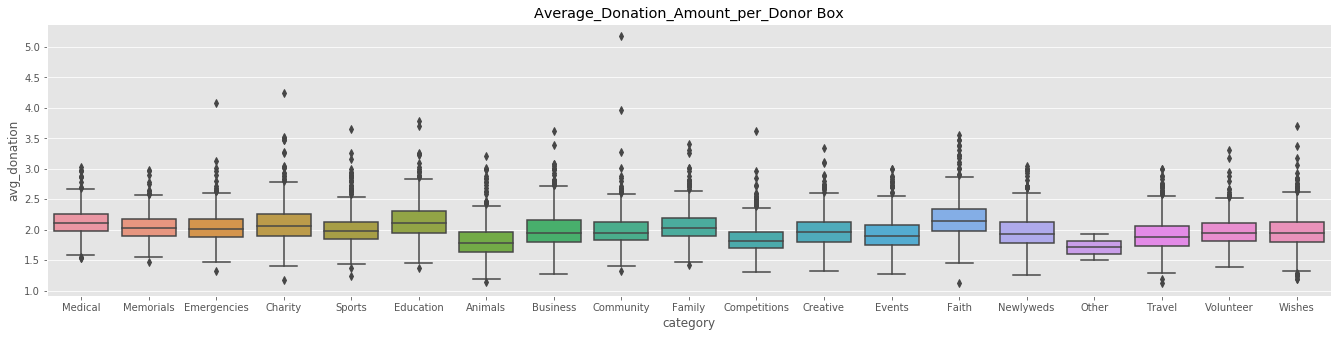

In [20]:
#transformed boxplot of Average_Donation_Amount_per_Donor for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="avg_donation", data=df_numl)
x.set_title('Average_Donation_Amount_per_Donor Box')

Text(0.5,1,'Average_Donation_Amount_per_Day Box')

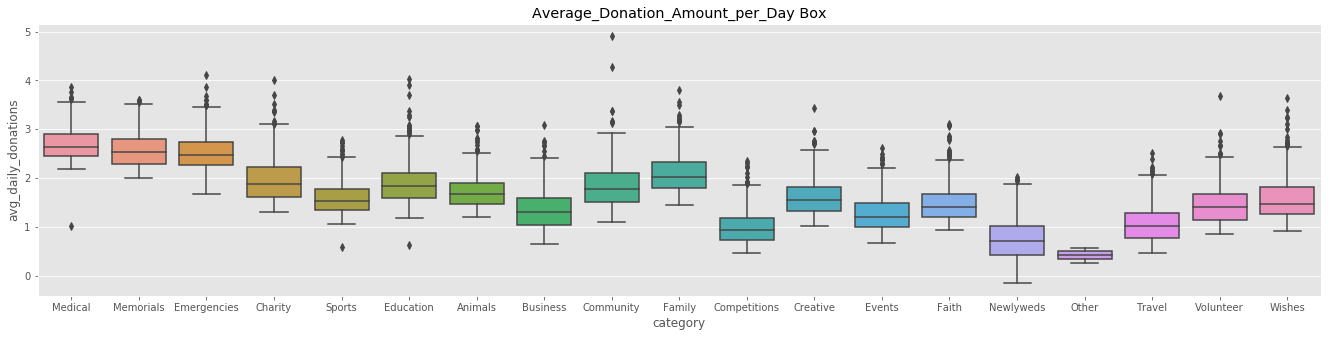

In [21]:
#transformed boxplot of Average_Donation_Amount_per_Day for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="avg_daily_donations", data=df_numl)
x.set_title('Average_Donation_Amount_per_Day Box')

Text(0.5,1,'Average_Shares_per_Donor Box')

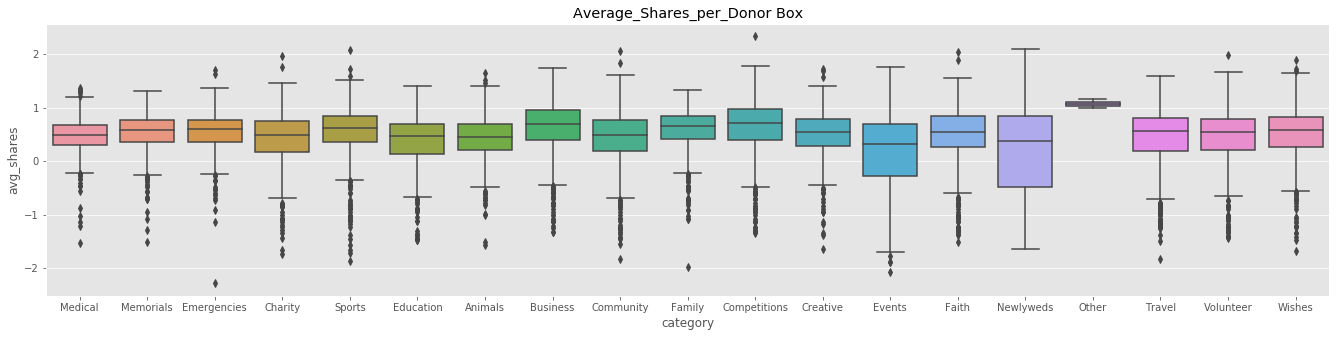

In [22]:
#transformed boxplot of Average_Shares_per_Donor for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="avg_shares", data=df_numl)
x.set_title('Average_Shares_per_Donor Box')

Text(0.5,1,'Average_Shares_per_Day Box')

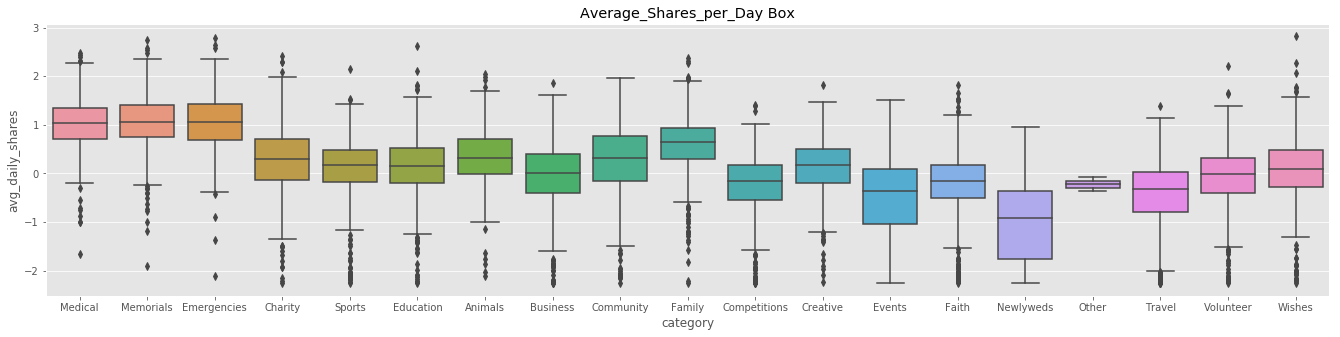

In [23]:
#transformed boxplot of Average_Shares_per_Day for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="avg_daily_shares", data=df_numl)
x.set_title('Average_Shares_per_Day Box')

Text(0.5,1,'Days Running Box(log10)')

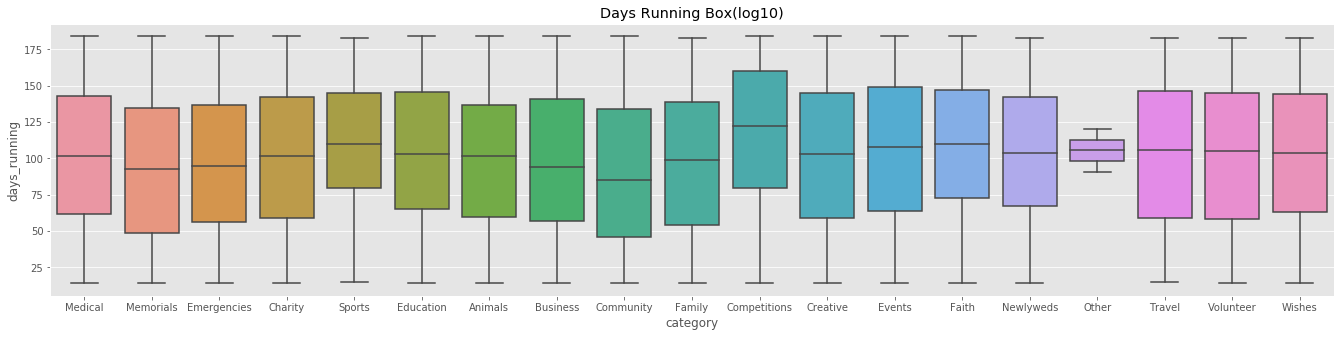

In [24]:
#boxplot of Days Running for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="days_running", data=df_numl)
x.set_title('Days Running Box(log10)')

Text(0.5,1,'Polarity Box')

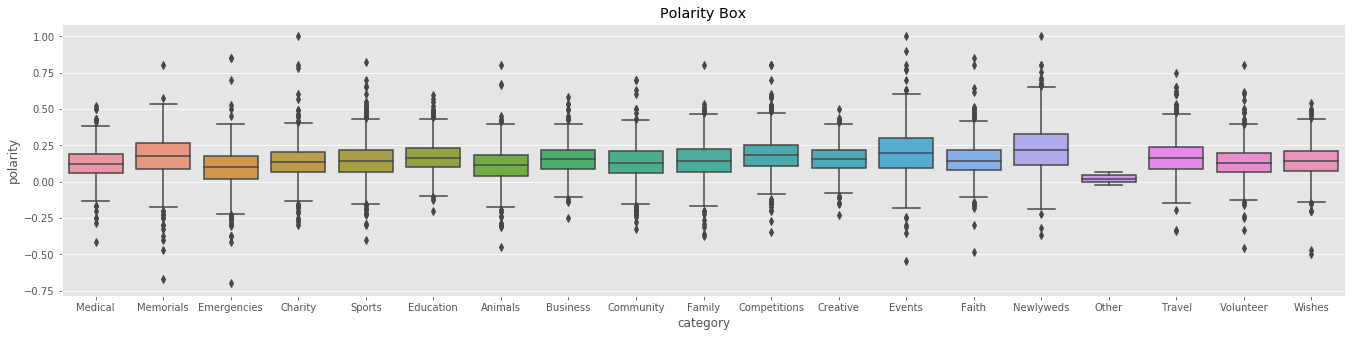

In [25]:
#boxplot of polarity for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="polarity", data=df_numl)
x.set_title('Polarity Box')

Text(0.5,1,'Subjectivity Box')

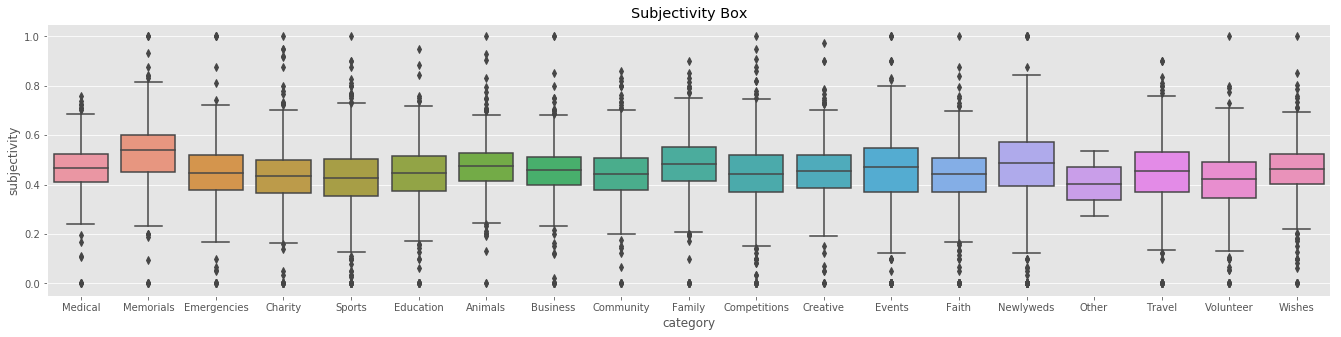

In [26]:
#boxplot of subjectivity for each category
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="subjectivity", data=df_numl)
x.set_title('Subjectivity Box')

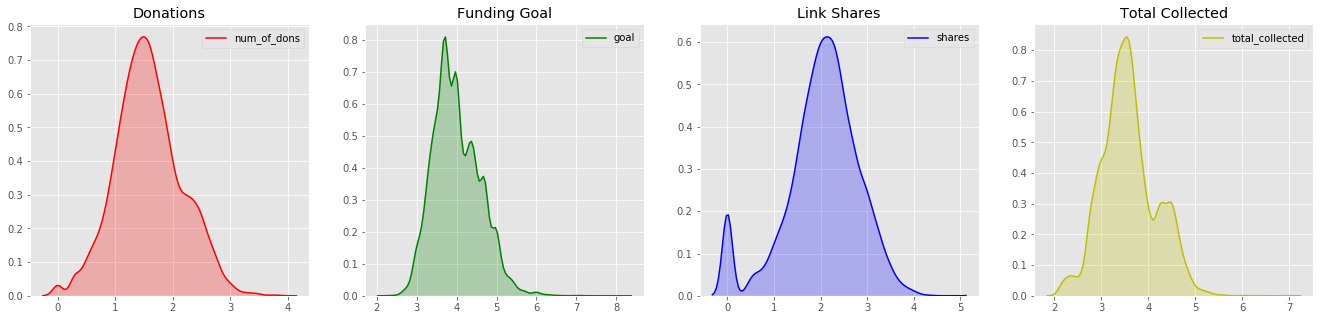

In [27]:
#density plots for transformed numerical variables
import seaborn as sns

fig, ax =plt.subplots(1,4, figsize=(23,5))

x = sns.kdeplot(df_numl['num_of_dons'], shade = True, ax=ax[0], color="r")
x.set_title("Donations")

y = sns.kdeplot(df_numl['goal'], shade = True, ax=ax[1], color="g")
y.set_title("Funding Goal")

q = sns.kdeplot(df_numl['total_collected'], shade = True, ax=ax[3], color="y")
q.set_title("Total Collected")

z = sns.kdeplot(df_numl['shares'], shade = True, ax=ax[2], color="b")
z.set_title("Link Shares")

plt.show()

Text(0.5,1,'Average_Donations_per_Day log10(#)')

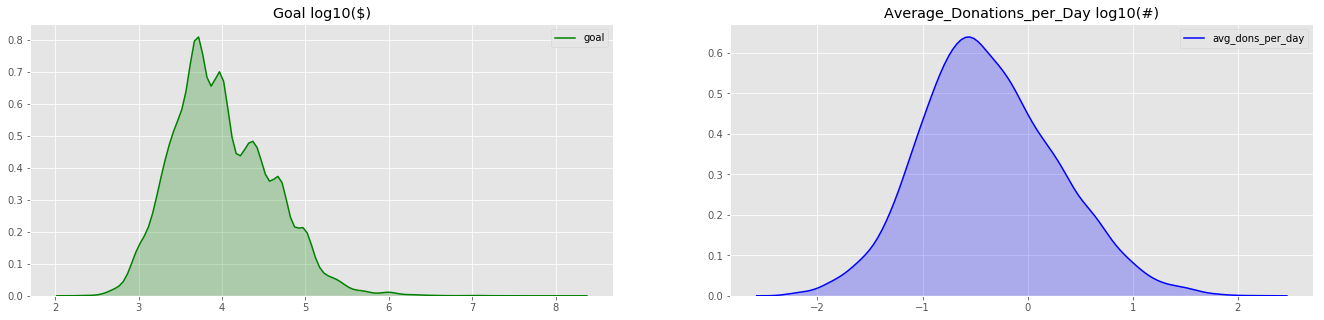

In [28]:
#density plots cont.
fig, ax =plt.subplots(1, 2, figsize=(23,5))

y = sns.kdeplot(df_numl['goal'],shade=True, ax=ax[0], color="g")
y.set_title("Goal log10($)")

x = sns.kdeplot(df_numl['avg_dons_per_day'], shade=True, ax=ax[1], color="b")
x.set_title("Average_Donations_per_Day log10(#)")

Text(0.5,1,'Average_Daily_Donations log10($/day)')

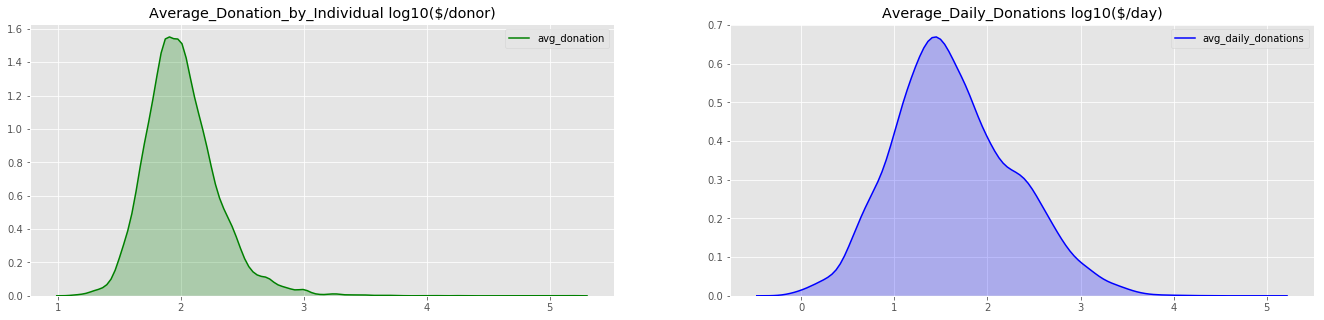

In [29]:
#density plots cont.
fig, ax =plt.subplots(1, 2, figsize=(23,5))

y = sns.kdeplot(df_numl['avg_donation'], shade = True, ax=ax[0], color="g")
y.set_title("Average_Donation_by_Individual log10($/donor)")

z = sns.kdeplot(df_numl['avg_daily_donations'], shade = True, ax=ax[1], color="b")
z.set_title("Average_Daily_Donations log10($/day)")

Text(0.5,1,'Average_Daily_Shares log10(shares/day)')

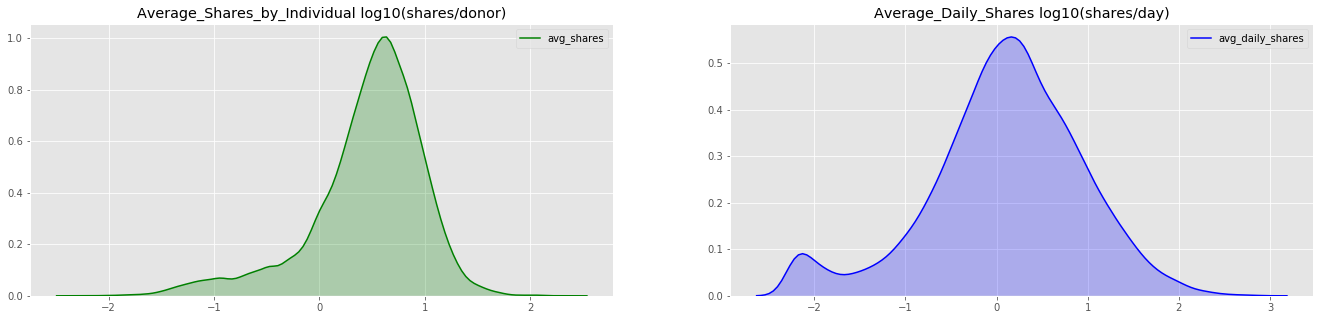

In [30]:
#density plots cont.
fig, ax =plt.subplots(1, 2, figsize=(23,5))

j = sns.kdeplot(df_numl['avg_shares'], shade = True, ax=ax[0], color="g")
j.set_title("Average_Shares_by_Individual log10(shares/donor)")

k = sns.kdeplot(df_numl['avg_daily_shares'], shade = True, ax=ax[1], color="b")
k.set_title("Average_Daily_Shares log10(shares/day)")

In [31]:
df_numl = df_numl.reset_index(drop=True)

## Clustering

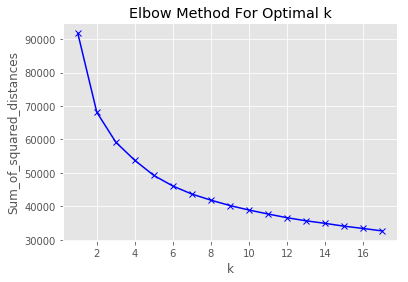

In [36]:
#drop category labels, drop original numerical features and scale remaining columns
scale = StandardScaler()
X = df_numl.drop(['category','days_running', 'num_of_dons', 'shares', 'total_collected'], axis=1)
X = scale.fit_transform(X)


#run kmeans for k=range(1,18) and calculate error
Sum_of_squared_distances = []
K = range(1,18)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)


#plot error for each value of k    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [91]:
#k=5
km = KMeans(n_clusters=5)
X = df_numl.drop(['category','days_running', 'num_of_dons', 'shares', 'total_collected', 'Cluster'], axis=1)
X_c = km.fit_predict(X)


#append cluster labels to dataframe
df_numl['Cluster'] = X_c


#find most common cluster assignment for each category
C_5 = df_numl.groupby('category').agg({'Cluster': lambda x: x.mode()})
C_5 = C_5.reset_index().sort_values('Cluster').set_index(['category'])


#dummy out Cluster labels into 5 columns
df_dum = pd.get_dummies(df_numl, columns=['Cluster'])


#create table showing % of each category is represented in each cluster
grp = df_dum.groupby('category').agg({'Cluster_0':'sum','Cluster_1':'sum',
                   'Cluster_2':'sum','Cluster_3':'sum',
                   'Cluster_4':'sum'})

clus_table = round(grp.div(grp.sum(axis=1),axis=0),2)
clus_table['Majority_Group'] = C_5['Cluster']
clus_table = clus_table.reset_index().sort_values('Majority_Group').set_index(['category'])
clus_table['Pct_in_Majority'] = clus_table.drop('Majority_Group', axis=1).max(axis=1)
clus_table

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Majority_Group,Pct_in_Majority
category,,,,,,,
Animals,0.01,0.52,0.29,0.12,0.06,1,0.52
Sports,0.05,0.50,0.20,0.04,0.21,1,0.50
Family,0.01,0.46,0.18,0.35,0.00,1,0.46
Creative,0.04,0.43,0.25,0.07,0.22,1,0.43
Wishes,0.06,0.38,0.22,0.07,0.26,1,0.38
Community,0.04,0.39,0.29,0.21,0.07,1,0.39
Education,0.04,0.35,0.43,0.14,0.04,2,0.43
Charity,0.03,0.33,0.38,0.23,0.02,2,0.38
Emergencies,0.00,0.09,0.06,0.85,0.00,3,0.85


In [92]:
rf = RandomForestClassifier()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]


# Number of features to consider at every split
max_features = ['auto', 'sqrt']


# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 110)]
max_depth.append(None)


# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]


# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 25, 100, 300]


# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


#drop features not used for modeling
X = df_dum.drop(['category','days_running', 'num_of_dons', 'shares', 'total_collected', 'Cluster_0', 'Cluster_1','Cluster_2',
                 'Cluster_3','Cluster_4'], axis=1)


#introduce random normal variable as baseline for feature importance
X['Random_Noise'] = np.random.normal(0,1,len(X))


#target
y = df_dum['Cluster_0']


#randomized parameter testing
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv = 5, verbose=2, n_jobs = -1, scoring='accuracy')

rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 19.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 43, 44, 4...'min_samples_split': [5, 10, 20], 'min_samples_leaf': [5, 25, 100, 300], 'bootstrap': [True, False]},
          pre_di

In [93]:
print(rf_random.best_params_, rf_random.best_score_)

{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 73, 'bootstrap': False} 0.99511684687827


In [94]:
#grid search around best parameters from randomized models

X = df_dum.drop(['category','days_running', 'num_of_dons', 'shares', 'total_collected', 'Cluster_0', 'Cluster_1','Cluster_2',
                 'Cluster_3','Cluster_4'], axis=1)
X['Random_Noise'] = np.random.normal(0,1,len(X))
y = df_dum['Cluster_0']

param_grid = {'n_estimators': [1100,1200,1300],
               'max_features': ['auto'],
               'max_depth': [73],
               'min_samples_split': [10, 13, 7],
               'min_samples_leaf': [3, 5, 10, 15, 20],
               'bootstrap': [False]}


#parameter grid search
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, scoring='accuracy',verbose = 2)

grid_rf.fit(X, y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 12.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1100, 1200, 1300], 'max_features': ['auto'], 'max_depth': [73], 'min_samples_split': [10, 13, 7], 'min_samples_leaf': [3, 5, 10, 15, 20], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [95]:
print(grid_rf.best_params_,' : ', grid_rf.best_score_)

{'bootstrap': False, 'max_depth': 73, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 1300}  :  0.995291245204046


In [ ]:
#feature importance table for RF fit on Cluster_0
rf_encode_0 = pd.DataFrame({'Feature': X.columns, 'Importance Factor': grid_rf.best_estimator_.feature_importances_}).sort_values('Importance Factor', ascending=False)
rf_encode_0 = rf_encode_0.reset_index(drop=True)

In [97]:
rf = RandomForestClassifier()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]


# Number of features to consider at every split
max_features = ['auto', 'sqrt']


# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 110)]
max_depth.append(None)


# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]


# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 25, 100, 300]


# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


#drop features not used for modeling
X = df_dum.drop(['category','days_running', 'num_of_dons', 'shares', 'total_collected', 'Cluster_0', 'Cluster_1','Cluster_2',
                 'Cluster_3','Cluster_4'], axis=1)


#introduce random normal variable as baseline for feature importance
X['Random_Noise'] = np.random.normal(0,1,len(X))


#target
y = df_dum['Cluster_1']


#randomized parameter testing
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv = 5, verbose=2, n_jobs = -1, scoring='accuracy')

rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 21.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 43, 44, 4...'min_samples_split': [5, 10, 20], 'min_samples_leaf': [5, 25, 100, 300], 'bootstrap': [True, False]},
          pre_di

In [98]:
print(rf_random.best_params_, rf_random.best_score_)

{'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 105, 'bootstrap': False} 0.9722706662016045


In [99]:
#grid search around best parameters from randomized models
param_grid = {'n_estimators': [1100, 1200, 1300],
               'max_features': ['auto'],
               'max_depth': [105],
               'min_samples_split': [5, 3, 7],
               'min_samples_leaf': [3, 5, 10, 15, 20],
               'bootstrap': [False]}

rf = RandomForestClassifier()


#parameter grid search
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, scoring='accuracy',verbose = 2)

grid_rf.fit(X, y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 17.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1100, 1200, 1300], 'max_features': ['auto'], 'max_depth': [105], 'min_samples_split': [5, 3, 7], 'min_samples_leaf': [3, 5, 10, 15, 20], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [ ]:
#feature importance table for RF fit on Cluster_1
rf_encode_1 = pd.DataFrame({'Feature': X.columns, 'Importance Factor': grid_rf.best_estimator_.feature_importances_}).sort_values('Importance Factor', ascending=False)
rf_encode_1 = rf_encode_1.reset_index(drop=True)

In [101]:
rf = RandomForestClassifier()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]


# Number of features to consider at every split
max_features = ['auto', 'sqrt']


# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 110)]
max_depth.append(None)


# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]


# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 25, 100, 300]


# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


#drop features not used for modeling
X = df_dum.drop(['category','days_running', 'num_of_dons', 'shares', 'total_collected', 'Cluster_0', 'Cluster_1','Cluster_2',
                 'Cluster_3','Cluster_4'], axis=1)


#introduce random normal variable as baseline for feature importance
X['Random_Noise'] = np.random.normal(0,1,len(X))


#target
y = df_dum['Cluster_2']


#randomized parameter testing
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv = 5, verbose=2, n_jobs = -1, scoring='accuracy')

rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 40.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 43, 44, 4...'min_samples_split': [5, 10, 20], 'min_samples_leaf': [5, 25, 100, 300], 'bootstrap': [True, False]},
          pre_di

In [102]:
print(rf_random.best_params_, rf_random.best_score_)

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 48, 'bootstrap': False} 0.9775026159748866


In [103]:
#grid search around best parameters from randomized models
param_grid = {'n_estimators': [300,400,500],
               'max_features': ['sqrt'],
               'max_depth': [48],
               'min_samples_split': [5, 10, 15],
               'min_samples_leaf': [3, 5, 10, 15, 20],
               'bootstrap': [False]}


#parameter grid search
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, scoring='accuracy',verbose = 2)

grid_rf.fit(X, y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [300, 400, 500], 'max_features': ['sqrt'], 'max_depth': [48], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [3, 5, 10, 15, 20], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [ ]:
#feature importance table for RF fit on Cluster_2
rf_encode_2 = pd.DataFrame({'Feature': X.columns, 'Importance Factor': grid_rf.best_estimator_.feature_importances_}).sort_values('Importance Factor', ascending=False)
rf_encode_2 = rf_encode_2.reset_index(drop=True)

In [105]:
rf = RandomForestClassifier()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]


# Number of features to consider at every split
max_features = ['auto', 'sqrt']


# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 110)]
max_depth.append(None)


# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]


# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 25, 100, 300]


# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


#drop features not used for modeling
X = df_dum.drop(['category','days_running', 'num_of_dons', 'shares', 'total_collected', 'Cluster_0', 'Cluster_1','Cluster_2',
                 'Cluster_3','Cluster_4'], axis=1)


#introduce random normal variable as baseline for feature importance
X['Random_Noise'] = np.random.normal(0,1,len(X))


#target
y = df_dum['Cluster_3']


#randomized parameter testing
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv = 5, verbose=2, n_jobs = -1, scoring='accuracy')

rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 20.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 43, 44, 4...'min_samples_split': [5, 10, 20], 'min_samples_leaf': [5, 25, 100, 300], 'bootstrap': [True, False]},
          pre_di

In [106]:
print(rf_random.best_params_, rf_random.best_score_)

{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': False} 0.9845657481688176


In [107]:
#grid search around best parameters from randomized models
param_grid = {'n_estimators': [1900, 2000, 2100],
               'max_features': ['sqrt'],
               'max_depth': [13],
               'min_samples_split': [3, 5, 10, 15],
               'min_samples_leaf': [3, 5, 7, 10, 15],
               'bootstrap': [False]}


#parameter grid search
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, scoring='accuracy',verbose = 2)

grid_rf.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 33.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1900, 2000, 2100], 'max_features': ['sqrt'], 'max_depth': [13], 'min_samples_split': [3, 5, 10, 15], 'min_samples_leaf': [3, 5, 7, 10, 15], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [ ]:
#feature importance table for RF fit on Cluster_3
rf_encode_3 = pd.DataFrame({'Feature': X.columns, 'Importance Factor': grid_rf.best_estimator_.feature_importances_}).sort_values('Importance Factor', ascending=False)
rf_encode_3 = rf_encode_3.reset_index(drop=True)

In [109]:
rf = RandomForestClassifier()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]


# Number of features to consider at every split
max_features = ['auto', 'sqrt']


# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 110)]
max_depth.append(None)


# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]


# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 25, 100, 300]


# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


#drop features not used for modeling
X = df_dum.drop(['category','days_running', 'num_of_dons', 'shares', 'total_collected', 'Cluster_0', 'Cluster_1','Cluster_2',
                 'Cluster_3','Cluster_4'], axis=1)


#introduce random normal variable as baseline for feature importance
X['Random_Noise'] = np.random.normal(0,1,len(X))


#target
y = df_dum['Cluster_4']


#randomized parameter testing
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv = 5, verbose=2, n_jobs = -1, scoring='accuracy')

rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 25.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 43, 44, 4...'min_samples_split': [5, 10, 20], 'min_samples_leaf': [5, 25, 100, 300], 'bootstrap': [True, False]},
          pre_di

In [110]:
print(rf_random.best_params_, rf_random.best_score_)

{'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 73, 'bootstrap': False} 0.9768050226717824


In [111]:
#grid search around best parameters from randomized models
param_grid = {'n_estimators': [1500,1600,1700],
               'max_features': ['sqrt'],
               'max_depth': [73],
               'min_samples_split': [5, 3, 7],
               'min_samples_leaf': [3, 5, 10,15],
               'bootstrap': [False]}


#parameter grid search
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, scoring='accuracy',verbose = 2)

grid_rf.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 17.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1500, 1600, 1700], 'max_features': ['sqrt'], 'max_depth': [73], 'min_samples_split': [5, 3, 7], 'min_samples_leaf': [3, 5, 10, 15], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [ ]:
#feature importance table for RF fit on Cluster_4
rf_encode_4 = pd.DataFrame({'Feature': X.columns, 'Importance Factor': grid_rf.best_estimator_.feature_importances_}).sort_values('Importance Factor', ascending=False)
rf_encode_4 = rf_encode_4.reset_index(drop=True)

In [ ]:
y = [rf_encode_0, rf_encode_1, rf_encode_2, rf_encode_3, rf_encode_4]

#rename features for easier interpretation
for x in y:
    x['Feature'] = x['Feature'].str.replace('avg_daily_shares', 'avg_shares_per_day')
    x['Feature'] = x['Feature'].str.replace('avg_daily_donations', 'avg_collected_amount_per_day')
    x['Feature'] = x['Feature'].str.replace('avg_donation', 'avg_donation_amount_per_donor')
    x['Feature'] = x['Feature'].str.replace('avg_shares', 'avg_shares_per_donor')
    x['Feature'] = x['Feature'].str.replace('avg_dons_per_day', 'avg_donation_count_per_day')
    x['Feature'] = x['Feature'].str.replace('avg_shares_per_donor_per_day', 'avg_shares_per_day')

In [115]:
rf_encode_0

,Feature,Importance Factor
0,avg_shares_per_day,0.554433
1,avg_shares_per_donor,0.338195
2,avg_donation_count_per_day,0.050259
3,avg_collected_amount_per_day,0.029567
4,goal,0.015654
5,avg_donation_amount_per_donor,0.006840
6,polarity,0.002135
7,subjectivity,0.001646
8,Random_Noise,0.001271


In [116]:
rf_encode_1

,Feature,Importance Factor
0,avg_shares_per_day,0.337860
1,avg_collected_amount_per_day,0.239067
2,avg_donation_count_per_day,0.189729
3,goal,0.096221
4,avg_shares_per_donor,0.093402
5,avg_donation_amount_per_donor,0.026741
6,Random_Noise,0.005949
7,subjectivity,0.005821
8,polarity,0.005209


In [117]:
rf_encode_2

,Feature,Importance Factor
0,avg_shares_per_day,0.318997
1,avg_collected_amount_per_day,0.205685
2,avg_shares_per_donor,0.177708
3,goal,0.128826
4,avg_donation_count_per_day,0.112756
5,avg_donation_amount_per_donor,0.036234
6,polarity,0.006698
7,subjectivity,0.006664
8,Random_Noise,0.006431


In [118]:
rf_encode_3

,Feature,Importance Factor
0,avg_collected_amount_per_day,0.377479
1,avg_donation_count_per_day,0.290790
2,avg_shares_per_day,0.175257
3,goal,0.110320
4,avg_shares_per_donor,0.020885
5,avg_donation_amount_per_donor,0.016666
6,subjectivity,0.002962
7,Random_Noise,0.002892
8,polarity,0.002748


In [191]:
rf_encode_4

,Feature,Importance Factor
0,avg_collected_amount_per_day,0.302195
1,avg_donation_count_per_day,0.222872
2,avg_shares_per_donor,0.153765
3,avg_shares_per_day,0.153568
4,goal,0.131723
5,avg_donation_amount_per_donor,0.022189
6,Random_Noise,0.004857
7,polarity,0.004425
8,subjectivity,0.004407


In [122]:
clus_table

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Majority_Group,Pct_in_Majority
category,,,,,,,
Animals,0.01,0.52,0.29,0.12,0.06,1,0.52
Sports,0.05,0.50,0.20,0.04,0.21,1,0.50
Family,0.01,0.46,0.18,0.35,0.00,1,0.46
Creative,0.04,0.43,0.25,0.07,0.22,1,0.43
Wishes,0.06,0.38,0.22,0.07,0.26,1,0.38
Community,0.04,0.39,0.29,0.21,0.07,1,0.39
Education,0.04,0.35,0.43,0.14,0.04,2,0.43
Charity,0.03,0.33,0.38,0.23,0.02,2,0.38
Emergencies,0.00,0.09,0.06,0.85,0.00,3,0.85


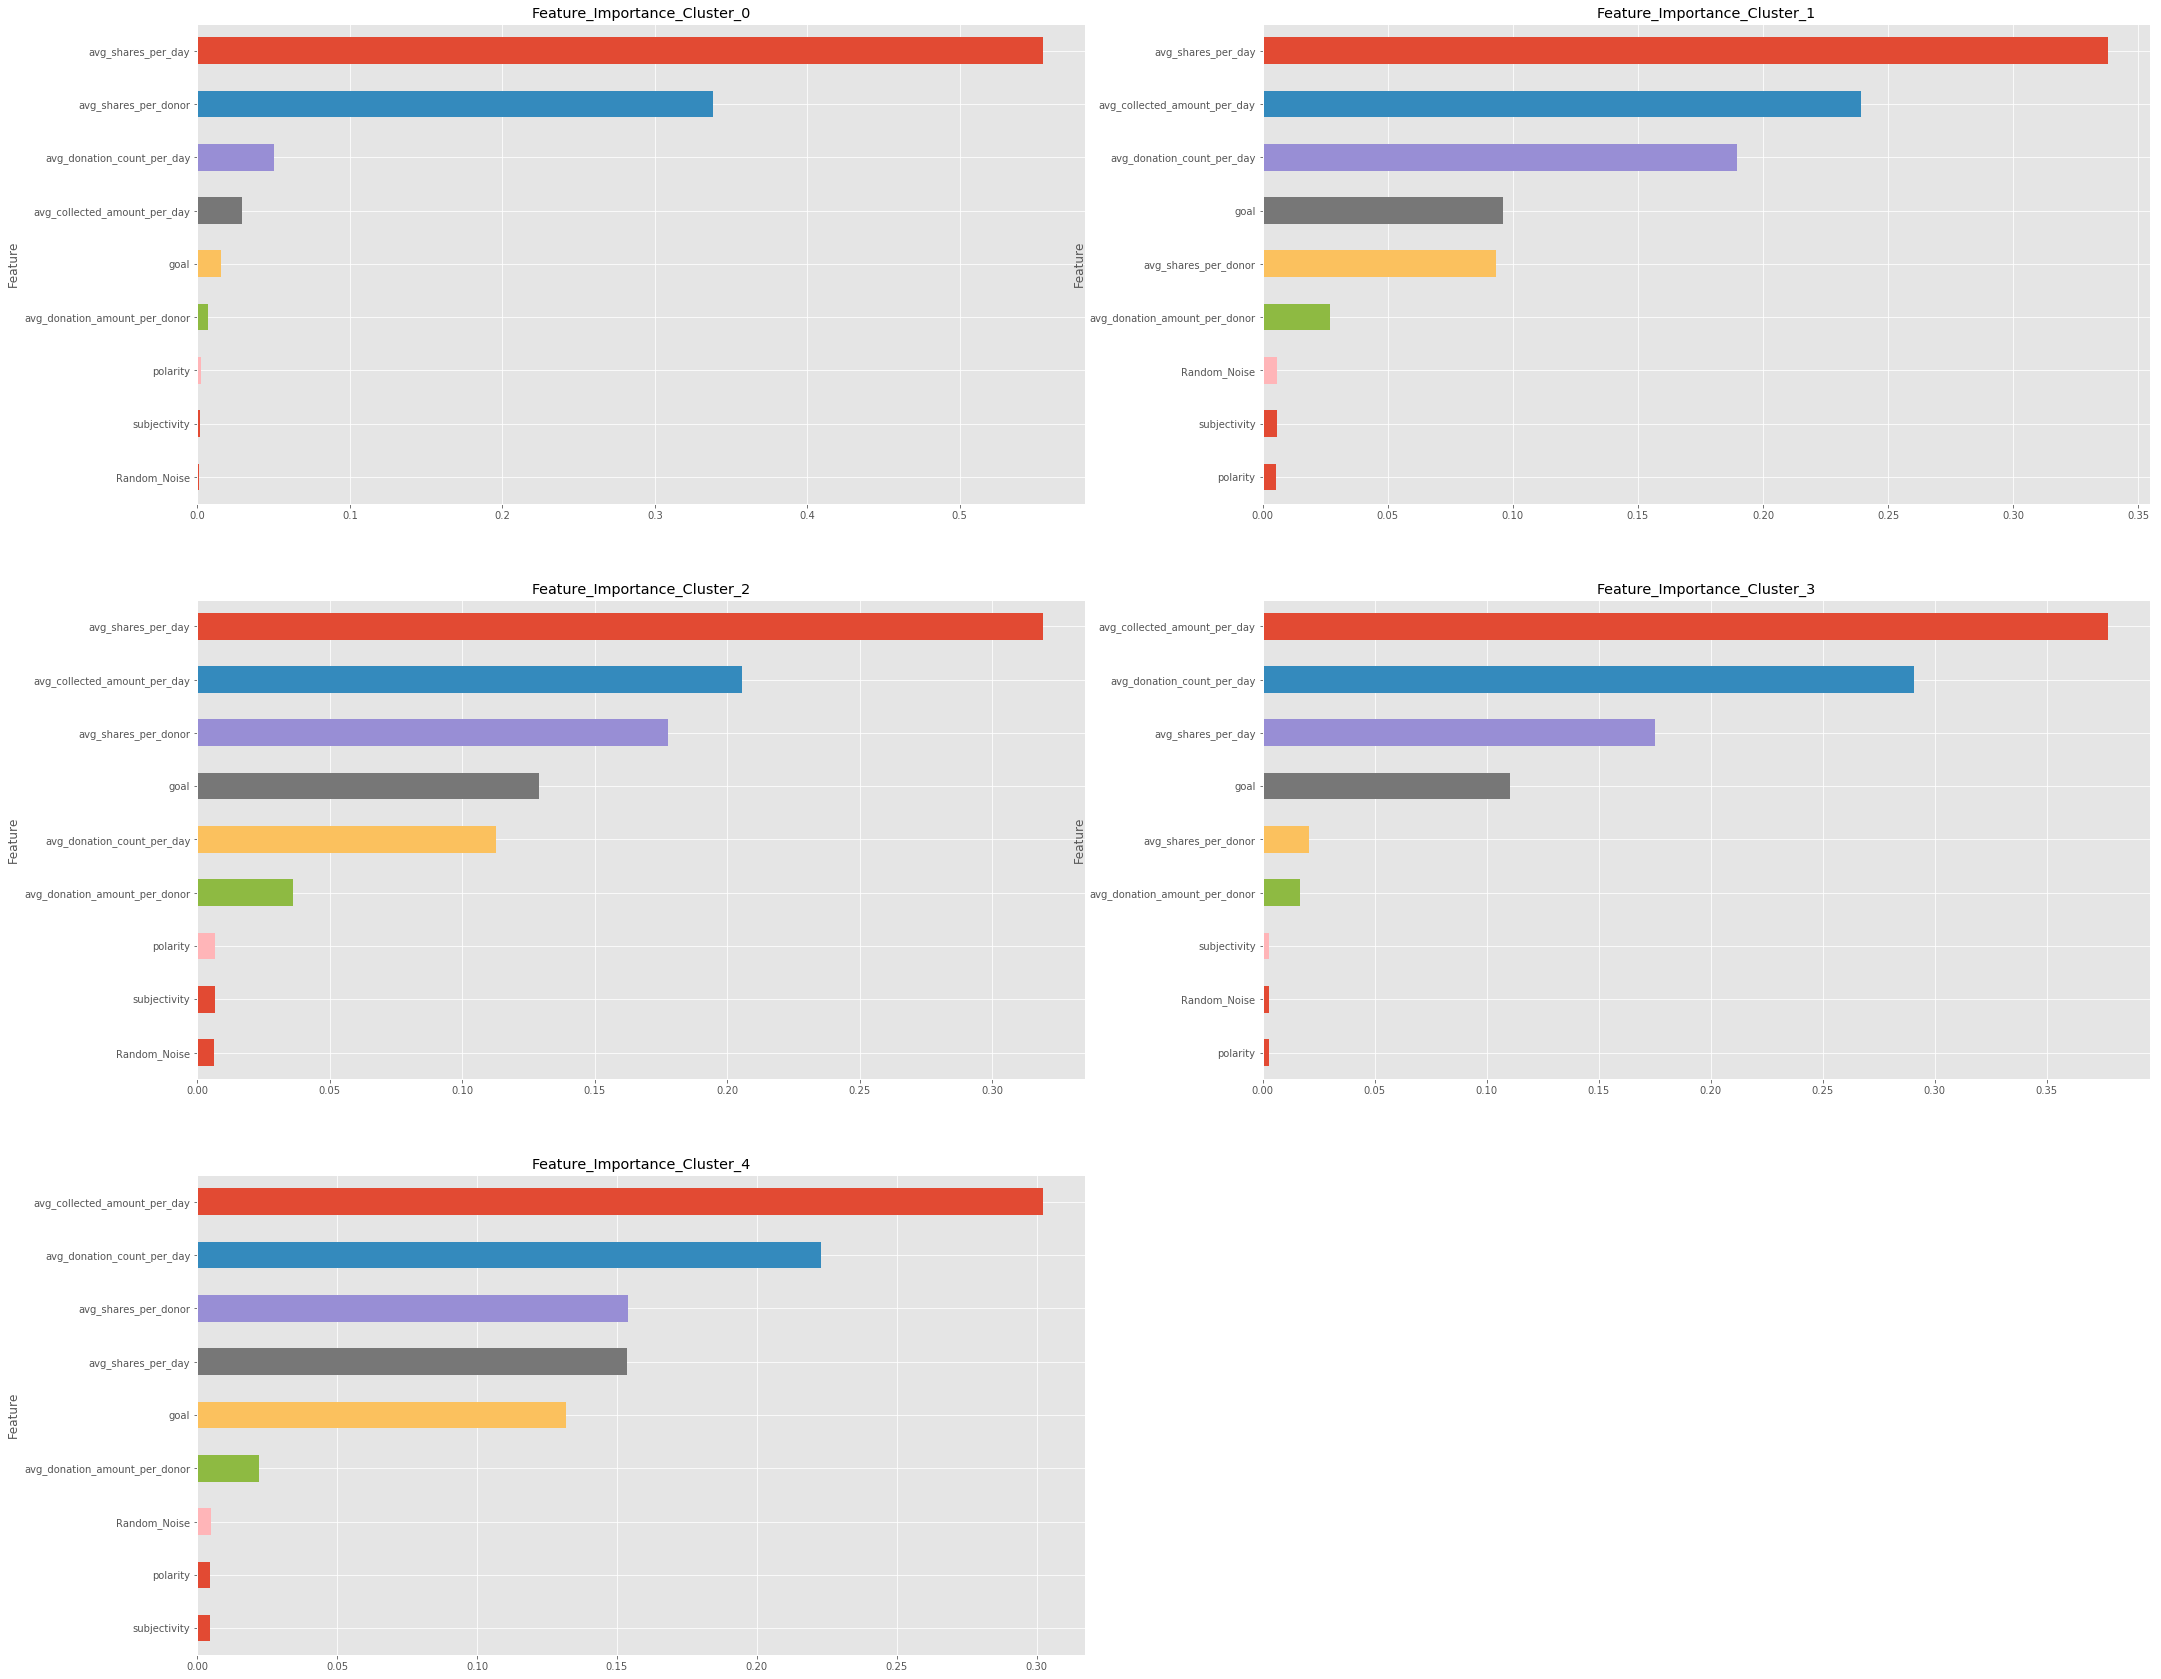

In [197]:
#plot feature importance tables for each cluster
fig, ax =plt.subplots(3,2, figsize=(35,30))

x0 = rf_encode_0.plot.barh(x='Feature', y='Importance Factor', title='Feature_Importance_Cluster_0', ax=ax[0,0], legend=False).invert_yaxis()
x1 = rf_encode_1.plot.barh(x='Feature', y='Importance Factor', title='Feature_Importance_Cluster_1', ax=ax[0,1], legend=False).invert_yaxis()
x2 = rf_encode_2.plot.barh(x='Feature', y='Importance Factor', title='Feature_Importance_Cluster_2', ax=ax[1,0], legend=False).invert_yaxis()
x3 = rf_encode_3.plot.barh(x='Feature', y='Importance Factor', title='Feature_Importance_Cluster_3', ax=ax[1,1], legend=False).invert_yaxis()
x4 = rf_encode_4.plot.barh(x='Feature', y='Importance Factor', title='Feature_Importance_Cluster_4', ax=ax[2,0], legend=False).invert_yaxis()

fig.delaxes(ax[2,1])

plt.show()

In [ ]:
#assign each cluster centroid to a variable
cc_0 = km.cluster_centers_[0]
cc_1 = km.cluster_centers_[1]
cc_2 = km.cluster_centers_[2]
cc_3 = km.cluster_centers_[3]
cc_4 = km.cluster_centers_[4]

In [144]:
#new dataframe of only cluster centroids
x = [cc_0, cc_1, cc_2, cc_3, cc_4]
y = df_numl.drop(['category','days_running', 'num_of_dons', 'shares', 'total_collected', 'Cluster'], axis=1).columns

ccdf = pd.DataFrame(data=x, columns=y)


#rename columns to match feature importance tables
ccdf = ccdf.rename(columns={'avg_daily_shares':'avg_shares_per_day', 'avg_daily_donations':'avg_collected_amount_per_day',
                            'avg_donation':'avg_donation_amount_per_donor', 'avg_shares':'avg_shares_per_donor',
                            'avg_dons_per_day':'avg_donation_count_per_day'})

#new index to indicate cluster
ccdf = ccdf.rename({0:'cc_0', 1:'cc_1', 2:'cc_2', 3:'cc_3', 4:'cc_4'})
ccdf

,goal,avg_donation_count_per_day,avg_donation_amount_per_donor,avg_collected_amount_per_day,avg_shares_per_donor,avg_shares_per_day,polarity,subjectivity
cc_0,3.580740,-1.006237,2.092737,1.086500,-0.682629,-1.688867,0.195190,0.445649
cc_1,3.979586,-0.237024,1.929463,1.692439,0.754056,0.517032,0.147243,0.448618
cc_2,4.151786,-0.393343,2.114476,1.721133,0.163186,-0.230157,0.148355,0.442894
cc_3,4.690625,0.552424,2.029507,2.581931,0.555671,1.108095,0.127943,0.469726
cc_4,3.524539,-0.967816,1.968594,1.000779,0.675213,-0.292603,0.174492,0.447818


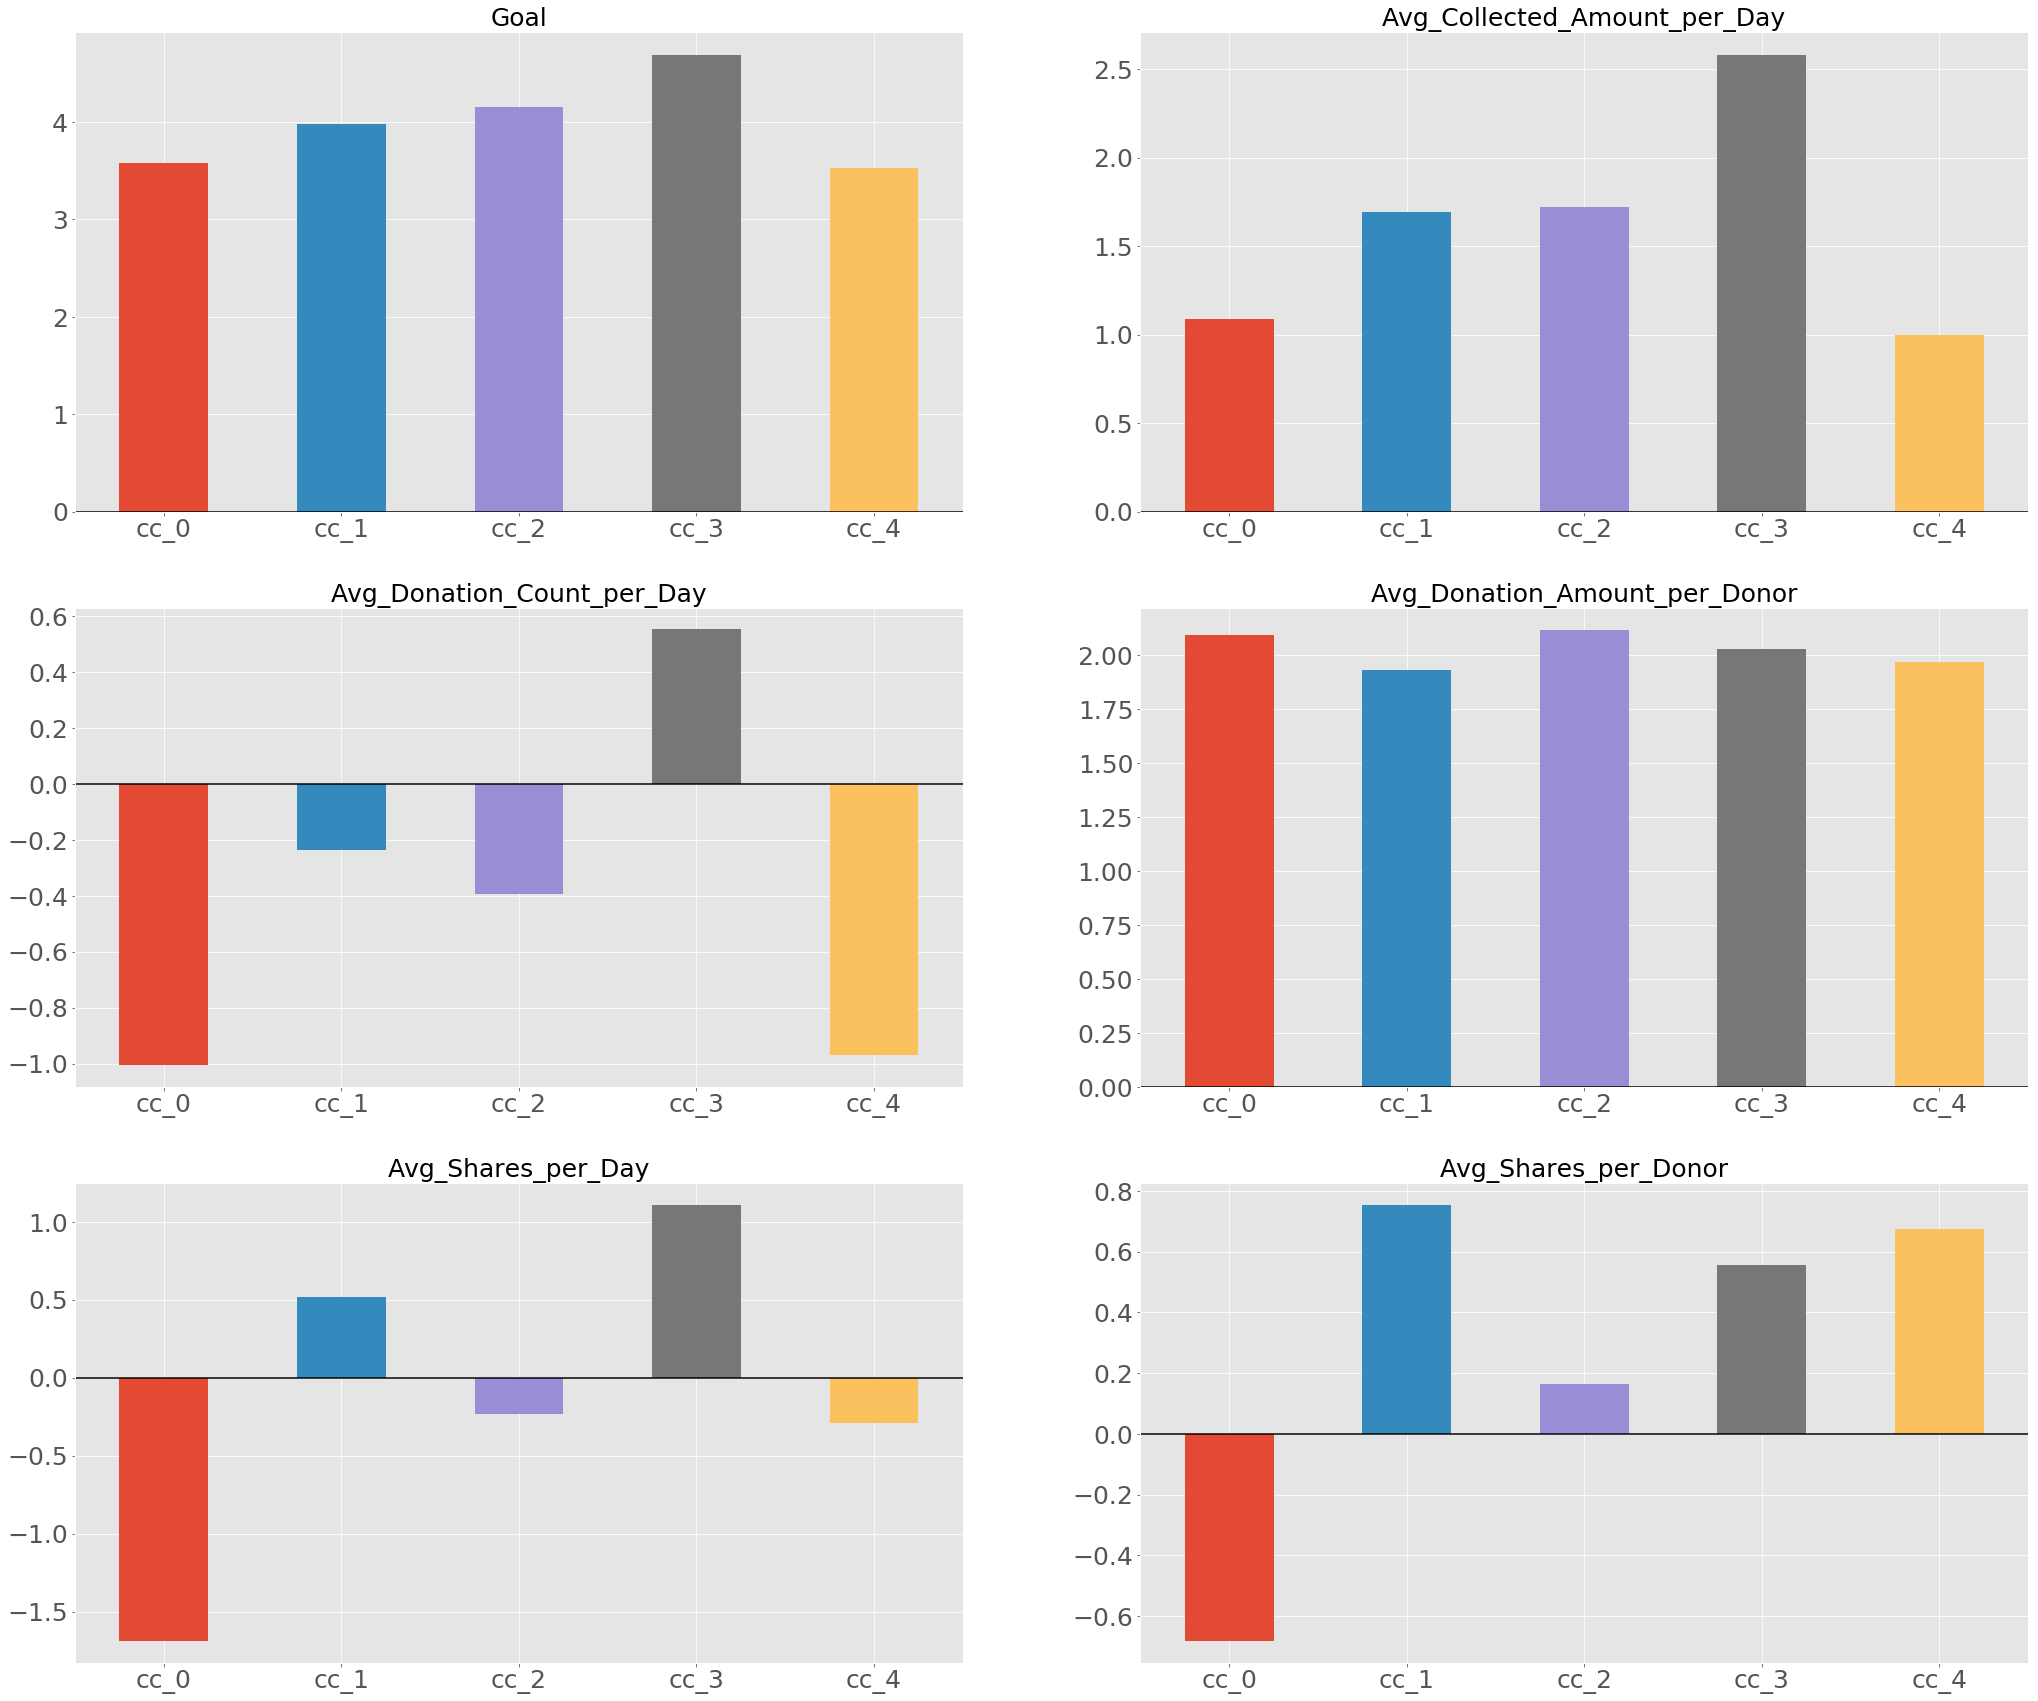

In [203]:
#bar graphs comparing centroid values for each feature
fig, ax = plt.subplots(3,2, figsize=(35,30))

x5 = ccdf.plot.bar(y='goal', ax=ax[0,0], rot=0, legend=False, fontsize=25)
x5.set_title('Goal', fontsize=25)
x5.axhline(0, color='black')

x0 = ccdf.plot.bar(y='avg_collected_amount_per_day', ax=ax[0,1], rot=0, legend=False, fontsize=25)
x0.set_title('Avg_Collected_Amount_per_Day', fontsize=25)
x0.axhline(0, color='black')

x1 = ccdf.plot.bar(y='avg_donation_count_per_day', ax=ax[1,0], rot=0, legend=False, fontsize=25)
x1.set_title('Avg_Donation_Count_per_Day', fontsize=25)
x1.axhline(0, color='black')

x2 = ccdf.plot.bar(y='avg_donation_amount_per_donor', ax=ax[1,1], rot=0, legend=False, fontsize=25)
x2.set_title('Avg_Donation_Amount_per_Donor', fontsize=25)
x2.axhline(0, color='black')

x3 = ccdf.plot.bar(y='avg_shares_per_day', ax=ax[2,0], rot=0, legend=False, fontsize=25)
x3.set_title('Avg_Shares_per_Day', fontsize=25)
x3.axhline(0, color='black')

x4 = ccdf.plot.bar(y='avg_shares_per_donor', ax=ax[2,1], rot=0, legend=False, fontsize=25)
x4.set_title('Avg_Shares_per_Donor', fontsize=25)
x4.axhline(0, color='black')

plt.show()